# Imports

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations

# Read Data

In [2]:
nodes_dir = 'data/nodes'
rel_dir = 'data/relationships'

movies = pd.read_csv(f'{nodes_dir}/Movie.csv')
genres = pd.read_csv(f'{nodes_dir}/Genre.csv')
persons = pd.read_csv(f'{nodes_dir}/Person.csv')
acted_in = pd.read_csv(f'{rel_dir}/ACTED_IN.csv')
worked_on = pd.read_csv(f'{rel_dir}/WORKED_ON.csv')
has_genre = pd.read_csv(f'{rel_dir}/HAS_GENRE.csv')

# Data Prep

In [516]:
def create_node_tuples_for_nx(df: pd.DataFrame, node_id:str, type: str):
    '''create a list of tuples needed for graph.add_nodes_from() method'''
    df = (df
            .assign(type=type,
                    # externalId=lambda df: f'{type}_' + df.internalId.astype(str)
                    )
        )
    return list(zip(df[node_id],
                        df.drop(columns=node_id).to_dict(orient='records')))
            

Movies

In [327]:
movie_node_df = (movies
    # create release year column
    .assign(releaseYear=lambda df: pd.to_datetime(df['releaseDate']).dt.year,)
    # filter by release year and revenue/budget
    .query("releaseYear >= 2010 & revenue > 0 & budget > 0")
    # remove movies with no cast
    .merge(acted_in[['endNodeInternalId']].drop_duplicates(), left_on='internalId', right_on='endNodeInternalId', how='inner')
    .drop(columns='endNodeInternalId')
    # filter movies that are duplicate titles
    .drop_duplicates(subset='title')
    [['title','releaseYear', 'internalId']]
)
movie_node_tuples = create_node_tuples_for_nx(movie_node_df, 'title', 'movie')

Acted In and Actors

In [328]:
# acted in relationships filtered to movies/actors in movie_node_df
acted_in_relationships = (acted_in
            # filter movies
            .merge(movie_node_df, left_on='endNodeInternalId', right_on='internalId', how='inner')
            .rename(columns={'internalId': 'movieId'})
            # filter actors
            .merge(persons[['name', 'internalId']], left_on='startNodeInternalId', right_on='internalId', how='inner')
            .rename(columns={'internalId': 'personId'})
            # filter to first 15 actors
            .query("order <= 15") 
        )

# persons with duplicate names. add a rank to the name to make it unique
dup_person_names = dict(acted_in_relationships[['personId', 'name']]
    .drop_duplicates()
    .pipe(lambda df: df.loc[df.duplicated(subset='name', keep=False)])
    .sort_values(by='name')
    .reset_index(drop=True)
    .assign(rank=lambda df: df.groupby('name').cumcount() + 1,
            name=lambda df: df.name + ' ' + df['rank'].astype(str))
    [['personId', 'name']].values
)

# actor nodes
actors = (acted_in_relationships[['personId', 'name']]
    .drop_duplicates()
    .assign(name_temp=lambda df: df.personId.map(dup_person_names),
            name=lambda df: df.name_temp.fillna(df.name))
    .drop(columns='name_temp')
)

# change name of actor in acted_in_relationships to account for duplicate names
acted_in_relationships = (acted_in_relationships
                            .drop(columns='name')
                            .merge(actors[['personId', 'name']], 
                                   on='personId', how='inner')
)

acted_in_edges = \
        list(zip(acted_in_relationships['name'],
         acted_in_relationships['title'], 
         acted_in_relationships[['order', 'character']].to_dict('records')))

In [329]:
genres_node_tuples = create_node_tuples_for_nx(genres[['name']], 'name', 'genre')

In [330]:
actor_node_tuples = create_node_tuples_for_nx(actors[['name']], 'name', 'actor')

In [331]:
has_genre_relationships = \
    (has_genre
         # filter to genres tied to movies in movie_node_df
        .merge(movie_node_df, 
               left_on='startNodeInternalId',
               right_on='internalId',
               how='inner')
        .drop(columns='internalId')
        .merge(genres[['name', 'internalId']], 
               left_on='endNodeInternalId', right_on='internalId', how='inner')
        [['title', 'name']]  
)

has_genre_edges = list(zip(has_genre_relationships.title, has_genre_relationships.name))

In [332]:
graph = nx.DiGraph()
# add nodes
graph.add_nodes_from(movie_node_tuples)
graph.add_nodes_from(genres_node_tuples)
graph.add_nodes_from(actor_node_tuples)
graph.add_edges_from(acted_in_edges)
graph.add_edges_from(has_genre_edges)

# Movie Similarity

In [333]:
# pariwise combinations of movies
movie_pairs = list(combinations([m[0] for m in movie_node_tuples], 2))

In [334]:
# undirected version of graph
u_graph = nx.Graph(graph)

## Common Neighbors

In [335]:
# common neighbors (number of actors in common)
com_neighbors = nx.common_neighbor_centrality(u_graph, movie_pairs, 1)
com_neighbors_df = pd.DataFrame({'movie1': [x[0] for x in movie_pairs], 
                                'movie2': [x[1] for x in movie_pairs],
                                'common_neighbors': [x[2] for x in com_neighbors]})

In [336]:
com_neighbors_edges_df = (com_neighbors_df
    # arbitrarily chose 4 as the threshold for "similar casts"
    .query("common_neighbors > 4")
    
)

common_neigh_edges = list(zip(com_neighbors_edges_df['movie1'],
         com_neighbors_edges_df['movie2'], 
         com_neighbors_edges_df[['common_neighbors']].to_dict('records')))

## Create new graph for movies and their similarity based on cast

In [337]:
movie_similarity_graph = nx.Graph()
movie_similarity_graph.add_edges_from(common_neigh_edges)

# Community Detection

In [338]:
communities = list(nx.community.louvain_communities(movie_similarity_graph, weight='common_neighbors', resolution=10))

# Visualize

In [339]:
selected_movie = 'Iron Man 3'
iron_man_cluster = list([c for c in communities if selected_movie in c][0])

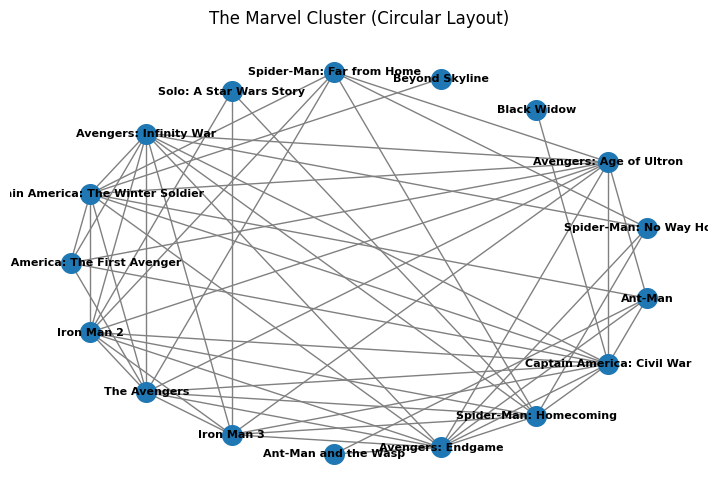

In [506]:
plt.figure(figsize=(9,6))
plt.title("The Marvel Cluster (Circular Layout)", color='black')

cluster_subgraph = movie_similarity_graph.subgraph(iron_man_cluster)
pos = nx.shell_layout(cluster_subgraph)

nx.draw(cluster_subgraph, 
        with_labels=True, 
        font_size=8,
        node_size=200,
        edge_color='grey',
        pos=pos,
        font_weight='bold',
        )

plt.show()

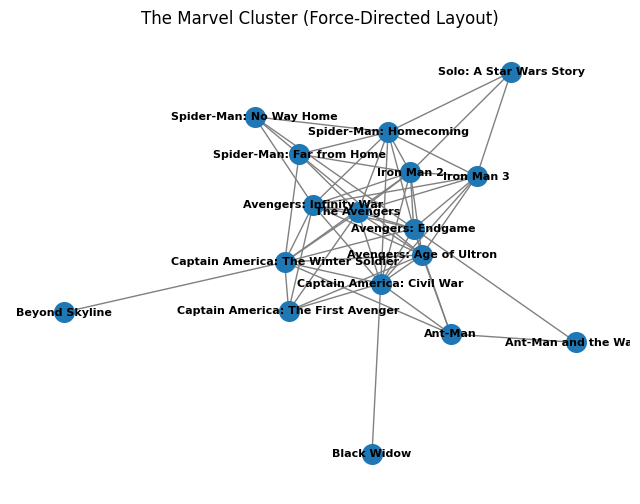

In [469]:
plt.figure(figsize=(8,6))
plt.title("The Marvel Cluster (Force-Directed Layout)", color='black')

cluster_subgraph = movie_similarity_graph.subgraph(iron_man_cluster)
pos = nx.spring_layout(cluster_subgraph)

nx.draw(cluster_subgraph, 
        with_labels=True, 
        font_size=8,
        node_size=200,
        edge_color='grey',
        pos=pos,
        font_weight='bold'
        )

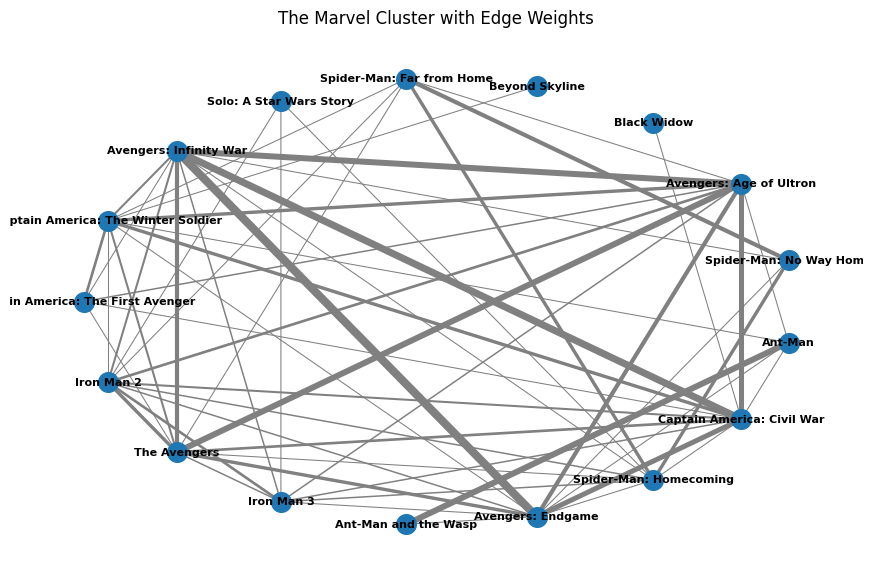

In [504]:
plt.figure(figsize=(11,7))
plt.title("The Marvel Cluster with Edge Weights", color='black')

cluster_subgraph = movie_similarity_graph.subgraph(iron_man_cluster)
weights = [cluster_subgraph[u][v]['common_neighbors'] for u,v in cluster_subgraph.edges()]
pos = nx.shell_layout(cluster_subgraph)

nx.draw(cluster_subgraph, 
        with_labels=True, 
        font_size=8,
        node_size=200,
        edge_color='grey',
        pos=pos,
        width=(np.array(weights) ** 2) * 0.03,
        font_weight='bold'
)

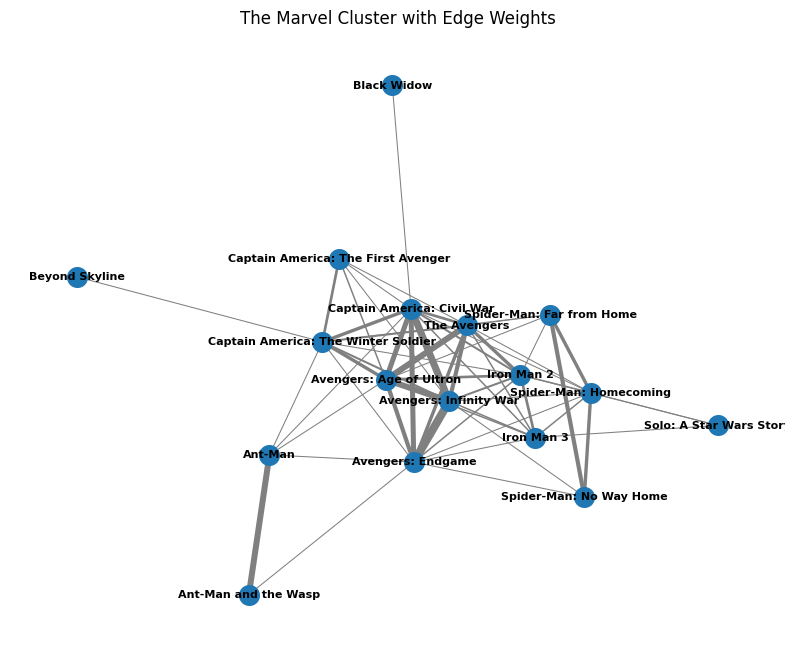

In [486]:
plt.figure(figsize=(10,8))
plt.title("The Marvel Cluster with Edge Weights", color='black')

cluster_subgraph = movie_similarity_graph.subgraph(iron_man_cluster)
pos = nx.spring_layout(cluster_subgraph)

nx.draw(cluster_subgraph, 
        with_labels=True, 
        font_size=8,
        node_size=200,
        edge_color='grey',
        pos=pos,
        font_weight='bold',       
        width=(np.array(weights) ** 2) * 0.03,
)

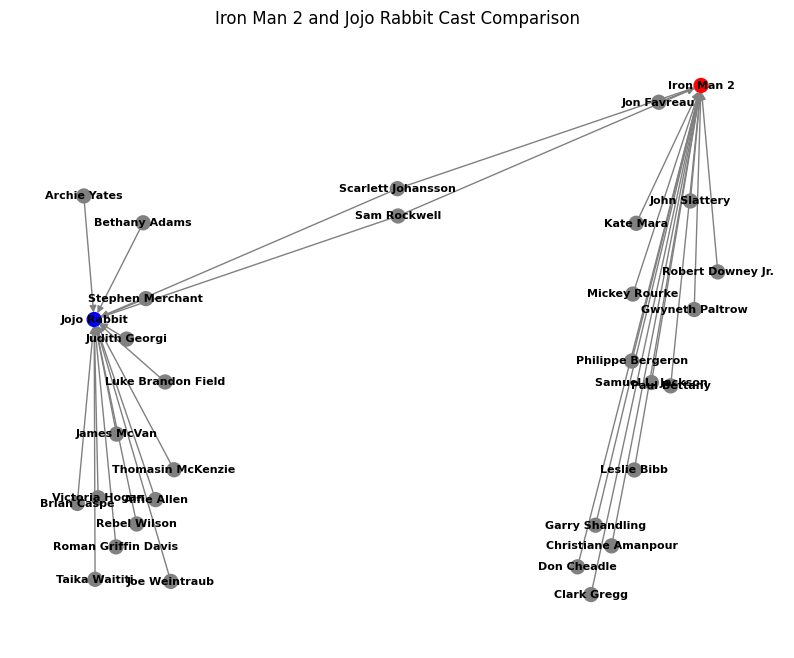

In [493]:
movie1 = 'Iron Man 2'
movie2 = 'Jojo Rabbit'
movie1_edges = [(e[0], e[1]) for e in graph.edges(data=True) if 'order' in e[2] and e[1] == movie1]
movie2_edges = [(e[0], e[1]) for e in graph.edges(data=True) if 'order' in e[2] and e[1] == movie2]

sg = graph.edge_subgraph(movie1_edges + movie2_edges)
plt.figure(figsize=(10,8))
plt.title("Iron Man 2 and Jojo Rabbit Cast Comparison", color='black')
nx.draw(sg,
        with_labels=True,
        font_size=8,
        node_size=100,
        edge_color='grey',
        font_weight='bold',
        node_color=['red' if n == movie1 else 'blue' if n == movie2 else 'grey' for n in sg.nodes()]
    )

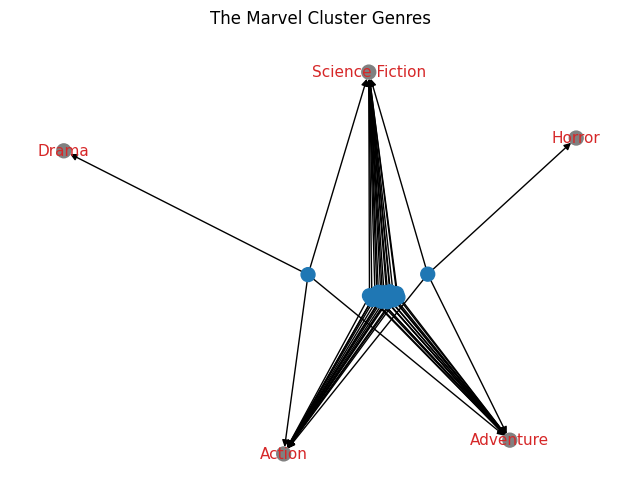

In [505]:
cluster_subgraph = graph.edge_subgraph(graph.edges(iron_man_cluster))
pos = nx.spring_layout(cluster_subgraph)
node_colors = ['tab:blue' if n not in genres.name.values else 'gray' for n in cluster_subgraph.nodes()]
# node_size = [100 * d if n in genres.name.values else 100 for n,d in dict(cluster_subgraph.degree()).items()]
plt.figure(figsize=(8,6))
plt.title("The Marvel Cluster Genres", color='black')

nx.draw(cluster_subgraph,
        pos=pos,
        with_labels=False,
        font_size=8,
        node_size=100,
        node_color=node_colors)

labels = {n: n for n in cluster_subgraph.nodes() if n in genres.name.values}
nx.draw_networkx_labels(cluster_subgraph, pos, labels, font_size=11, font_color='tab:red');

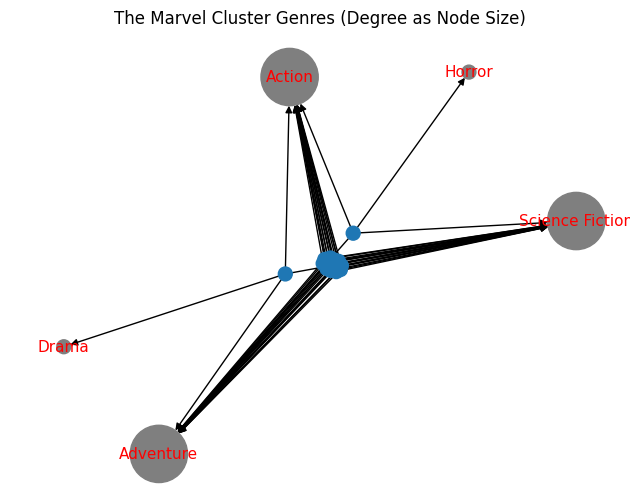

In [500]:
cluster_subgraph = graph.edge_subgraph(graph.edges(iron_man_cluster))
pos = nx.spring_layout(cluster_subgraph)
node_colors = ['tab:blue' if n not in genres.name.values else 'tab:gray' for n in cluster_subgraph.nodes()]
node_size = [100 * d if n in genres.name.values else 100 for n,d in dict(cluster_subgraph.degree()).items()]
plt.figure(figsize=(8,6))
plt.title("The Marvel Cluster Genres (Degree as Node Size)", color='black')
nx.draw(cluster_subgraph,
        pos=pos,
        with_labels=False,
        font_size=8,
        node_size=node_size,
        node_color=node_colors)

labels = {n: n for n in cluster_subgraph.nodes() if n in genres.name.values}
nx.draw_networkx_labels(cluster_subgraph, pos, labels, font_size=11, font_color='r');